In [1]:
import pandas as pd

train = pd.read_csv("train.csv")

holdout = pd.read_csv("test.csv")

print(holdout.head(5))

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    dummy_cols = ['Age_categories','Fare_categories','Title','Cabin_type','Sex']
    for col in dummy_cols:
        df = create_dummies(df,col)
    return df

train = process_df(train)
holdout = process_df(holdout)

In [11]:
print(train['SibSp'].value_counts())

print(train['Parch'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


In [12]:
#Combine SibSp and Parch to create new column Family_size

train['Family_size'] = train['SibSp']+train['Parch']

print(train['Family_size'].value_counts())

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family_size, dtype: int64


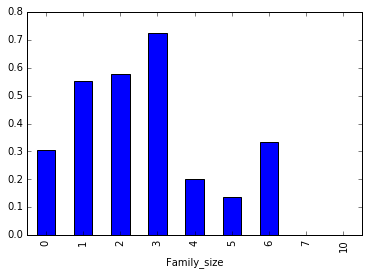

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
family_pivot = train.pivot_table(index = 'Family_size',values='Survived')
family_pivot.plot.bar()
plt.show()

In [22]:
#convert Family size to dummy variable
train = create_dummies(train, 'Family_size')

In [23]:
#Apply conversions to holdout df

holdout['Family_size'] = holdout['SibSp']+holdout['Parch']

holdout = create_dummies(holdout,'Family_size')

The SibSp and Parch columns both refer to family members of passengers.  We see that survival rates differ for passengers with different size families on board.  SibSp and Parch are combined into one column, Family_size, which is then converted to a dummy variable.

In [4]:
def is_alone(row):
    if row['SibSp'] == 0 and row['Parch'] == 0:
        val = 1
    else:
        val = 0
    return val

train['isalone'] = train.apply(is_alone, axis=1)
holdout['isalone'] = holdout.apply(is_alone, axis=1)

In [5]:
train['isalone'].value_counts()

1    537
0    354
Name: isalone, dtype: int64

In [7]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.dropna(axis=1)
    df = df._get_numeric_data()
    all_X = df.drop(['PassengerId','Survived'],axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    opt = all_X.columns[selector.support_]
    print(opt)
    return opt

cols = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,feat):
    all_X = df[feat]
    all_y = df['Survived']
    LR = {
        "name": "LogisticRegression",
        "estimator": LogisticRegression(),
        "hyperparameters":
        {
            "solver": ["newton-cg","lbfgs","liblinear"]
        }
    }
    KNN = {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
        {
            "n_neighbors":range(1,20,2),
            "weights": ['distance','uniform'],
            "algorithm": ['ball_tree','kd_tree','brute'],
            "p": [1,2]
        }
    }
    RF = {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
        {
            "n_estimators":[4,6,9],
            "criterion": ['entropy','gini'],
            "max_depth": [2,5,10],
            "max_features": ["log2",'sqrt'],
            "min_samples_leaf": [1,5,8],
            "min_samples_split": [2,3,5]
        }
    }
    
    dicts = [LR, KNN, RF]
    
    for d in dicts:
        print(d["name"])
        grid = GridSearchCV(estimator = d['estimator'],param_grid = d['hyperparameters'],cv=10)
        grid.fit(all_X, all_y)
        d['best_parameters'] = grid.best_params_
        d['best_score'] = grid.best_score_
        d['best_estimator'] = grid.best_estimator_
        print(d['best_parameters'])
        print(d['best_score'])
        
    return dicts


model = select_model(train,cols)
        
        
        

LogisticRegression
{'solver': 'liblinear'}
0.820426487093
KNeighborsClassifier
{'weights': 'uniform', 'algorithm': 'brute', 'p': 1, 'n_neighbors': 5}
0.775533108866
RandomForestClassifier
{'max_depth': 10, 'criterion': 'entropy', 'n_estimators': 9, 'min_samples_split': 3, 'max_features': 'log2', 'min_samples_leaf': 1}
0.83950617284


In [12]:
def save_submission_file(model, cols, filename):
    holdout_predictions = model.predict(holdout[cols])
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename, index=False)
    
    
print(model)

[{'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'best_score': 0.8204264870931538, 'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']}, 'best_parameters': {'solver': 'liblinear'}, 'name': 'LogisticRegression'}, {'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'best_score': 0.77553310886644222, 'best_estimator': KNeighborsClassifier(algor

In [13]:
save_submission_file(model[2]['best_estimator'],cols,"submission.csv")